# Instalki, importy + załadowanie sekretów 

In [ ]:
!pip install --quiet boto3
!pip install --quiet python-dotenv
!conda install -c conda-forge streamlit -y

In [51]:
import boto3
import os
import pandas as pd
from pycaret.regression import get_config, setup, compare_models, finalize_model, plot_model, save_model, load_model, predict_model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

# Połączenie do dysku  Digital Ocean i ściągnięcie danych 2024/3

In [3]:
s3 = boto3.client(
    "s3",
    # aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    # aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    # Endpoint jest potrzebny dlatego że używamy chmury innej niż AWS 
    # endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 
    # Gdybyśmy używali AWS to musielibyśmy natomiast podać region
    #region_name='eu-central-1'
)

In [60]:
BUCKET_NAME = "pioto1974"

In [64]:
# Pobieramy pliki
os.makedirs("raw", exist_ok=True)
s3.download_file(BUCKET_NAME, "halfmarathon_wroclaw_2024__final.csv", "raw/halfmarathon_wroclaw_2024__final.csv")
s3.download_file(BUCKET_NAME, "halfmarathon_wroclaw_2023__final.csv", "raw/halfmarathon_wroclaw_2023__final.csv")

In [40]:
df1 = pd.read_csv('raw/halfmarathon_wroclaw_2024__final.csv', sep=';')
df2 = pd.read_csv('raw/halfmarathon_wroclaw_2023__final.csv', sep=';')

# Transformacje. M.in.: połączenie danych 2024/3, usunięcie zduplikowanego nagłówka, usunięcie wierszy bez danych, pozostawienie zadych z zadania: płeć, wiek, tempo na 5 km i czas ukończenia półmaratonu wraz z zamianą na sekundy

In [41]:
# pozbycie się nagłówka df2
df2 = df2.iloc[1:]

# połączenie df1 i df2
df = pd.concat([df1, df2])

# wybranie kolumn 
df = df.loc[:, ['Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]

# usunięcie wierszy NaN
df = df.dropna(how='any')

# zamiana gender na 1 i 0
df['Płeć'] = df['Płeć'].replace({'M': 1, 'K': 0})

# usunięcie 1 znaku w komumnie kategoria wiekowa
df['Kategoria wiekowa'] = df['Kategoria wiekowa'].str.slice(start=1)

# zmiana czasu na sekundy
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])
    
df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)

# zmiana nazw kolumn na ENG
df = df.rename(columns={
    'Płeć': 'Gender',
    'Kategoria wiekowa': 'Age Category', 
    '5 km Czas': '5 km Time',
    'Czas': 'Time'
})
# usunięcie zduplikowanych indeksów po połączeniu
df = df.reset_index(drop=True)
# sprawdzenie NaN na koniec
has_nan_columns = df.isnull().any(axis=0)

has_nan_columns

Gender          False
Age Category    False
5 km Time       False
Time            False
dtype: bool

# Trening Modelu

In [42]:
exp = setup(
    data=df,
    target='Time',
    session_id=123,
    verbose=False,
)
best_model = compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,300.9051,172006.8296,414.4537,0.8831,0.0525,0.0393,0.1930
lightgbm,Light Gradient Boosting Machine,303.5384,175468.1897,418.6147,0.8808,0.0530,0.0396,0.1690
ridge,Ridge Regression,303.3759,185929.4231,430.5767,0.8738,0.0582,0.0396,0.0220
lr,Linear Regression,303.3926,185941.9275,430.5904,0.8738,0.0582,0.0396,0.0200
lasso,Lasso Regression,303.5424,186044.4363,430.7149,0.8737,0.0581,0.0396,0.0210
en,Elastic Net,303.6635,186126.2460,430.8127,0.8737,0.0581,0.0396,0.0200
llar,Lasso Least Angle Regression,303.5424,186044.4375,430.7149,0.8737,0.0581,0.0396,0.0210
omp,Orthogonal Matching Pursuit,303.7271,186181.6931,430.8782,0.8737,0.0582,0.0396,0.0190
br,Bayesian Ridge,303.5192,186046.9150,430.7193,0.8737,0.0581,0.0396,0.0250
huber,Huber Regressor,300.5652,189715.7620,434.9975,0.8712,0.0599,0.0389,0.0390


In [43]:
processed_data = get_config('X')
print(processed_data)

       Gender Age Category  5 km Time
10240       1           40       2051
15663       0           30       1693
15680       1           40       1683
13163       0           40       1687
7652        0           30       1923
...       ...          ...        ...
12480       0           20       1560
2838        1           40       1561
13170       1           40       1592
4741        1           30       1617
4613        1           40       1663

[18392 rows x 3 columns]


# Tuning

In [44]:
# wytrenujemy najlepsze modele z optymalnymi parametrami
tuned_best_models = [exp.tune_model(m, optimize="RMSE") for m in best_model]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,296.7786,158789.4721,398.4840,0.8937,0.0506,0.0391
1,296.8247,165584.0614,406.9202,0.8825,0.0521,0.0391
2,316.4227,194853.2770,441.4219,0.8691,0.0553,0.0412
3,307.6295,190059.1484,435.9577,0.8619,0.0554,0.0403
4,323.9215,209224.1367,457.4102,0.8589,0.0574,0.0419
5,324.4877,213267.2216,461.8086,0.8531,0.0567,0.0419
6,316.2913,194453.1566,440.9684,0.8681,0.0558,0.0414
7,311.7660,189707.7857,435.5546,0.8712,0.0551,0.0409
8,315.5394,185422.6130,430.6073,0.8775,0.0542,0.0409


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,290.9455,149426.4444,386.5572,0.9000,0.0494,0.0384
1,289.8108,157964.2688,397.4472,0.8879,0.0507,0.0382
2,309.0470,181944.7296,426.5498,0.8777,0.0537,0.0403
3,298.8713,173728.7357,416.8078,0.8738,0.0537,0.0394
4,302.3488,180310.1195,424.6294,0.8784,0.0540,0.0394
5,310.1033,190944.8860,436.9724,0.8684,0.0541,0.0403
6,314.0771,185137.4229,430.2760,0.8744,0.0547,0.0412
7,298.4017,176527.3016,420.1515,0.8802,0.0533,0.0392
8,301.3317,168974.0380,411.0645,0.8884,0.0522,0.0392


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,291.4769,174299.3268,417.4917,0.8833,0.0505,0.0382
1,289.1881,154769.0636,393.4070,0.8902,0.0502,0.0380
2,307.6569,180030.0755,424.2995,0.8790,0.0533,0.0401
3,297.5276,172465.8753,415.2901,0.8747,0.0530,0.0390
4,304.1317,213486.5024,462.0460,0.8560,0.0552,0.0394
5,312.1686,202348.2958,449.8314,0.8606,0.0547,0.0404
6,311.8191,179977.4448,424.2375,0.8779,0.0539,0.0408
7,301.4980,203970.7992,451.6313,0.8615,0.0549,0.0394
8,299.8557,164089.1323,405.0792,0.8916,0.0511,0.0389


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,291.5056,174333.5527,417.5327,0.8833,0.0505,0.0383
1,289.1669,154757.8995,393.3928,0.8902,0.0502,0.0380
2,307.6181,180038.5488,424.3095,0.8790,0.0534,0.0401
3,297.5482,172485.0663,415.3132,0.8747,0.0530,0.0390
4,304.1907,213492.4130,462.0524,0.8560,0.0552,0.0394
5,312.1482,202342.2063,449.8246,0.8606,0.0547,0.0404
6,311.9264,180075.5642,424.3531,0.8778,0.0539,0.0408
7,301.4661,203930.7448,451.5869,0.8615,0.0549,0.0394
8,299.8033,164053.6319,405.0353,0.8916,0.0511,0.0388


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,291.2357,174090.7817,417.2419,0.8835,0.0505,0.0382
1,289.5128,155033.8429,393.7434,0.8900,0.0502,0.0381
2,308.1791,180097.1376,424.3785,0.8790,0.0533,0.0401
3,297.4594,172328.3997,415.1246,0.8748,0.0530,0.0390
4,304.0996,213442.6526,461.9985,0.8560,0.0552,0.0394
5,312.2261,202341.5284,449.8239,0.8606,0.0547,0.0404
6,311.6239,179836.8818,424.0718,0.8780,0.0538,0.0408
7,301.6883,204224.6688,451.9122,0.8613,0.0549,0.0394
8,300.4546,164605.2899,405.7158,0.8913,0.0512,0.0389


Fitting 10 folds for each of 10 candidates, totalling 100 fits


# Wybór i zapisanie najlepszego modelu

In [45]:
best_model = exp.compare_models(best_model + tuned_best_models, sort="RMSE")plot_model(best_model, plot='error')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,300.9051,172006.8296,414.4537,0.8831,0.0525,0.0393,0.1670
5,Gradient Boosting Regressor,300.9051,172006.8296,414.4537,0.8831,0.0525,0.0393,0.1650
6,Light Gradient Boosting Machine,303.1049,174854.7280,417.8929,0.8812,0.0530,0.0396,0.1370
1,Light Gradient Boosting Machine,303.5384,175468.1897,418.6147,0.8808,0.0530,0.0396,0.1400
7,Ridge Regression,303.3579,185920.7384,430.5667,0.8738,0.0582,0.0396,0.0210
2,Ridge Regression,303.3759,185929.4231,430.5767,0.8738,0.0582,0.0396,0.0200
3,Linear Regression,303.3926,185941.9275,430.5904,0.8738,0.0582,0.0396,0.0220
8,Linear Regression,303.3926,185941.9275,430.5904,0.8738,0.0582,0.0396,0.0210
9,Lasso Regression,303.4634,185994.0162,430.6546,0.8738,0.0581,0.0396,0.0260
4,Lasso Regression,303.5424,186044.4363,430.7149,0.8737,0.0581,0.0396,0.0230


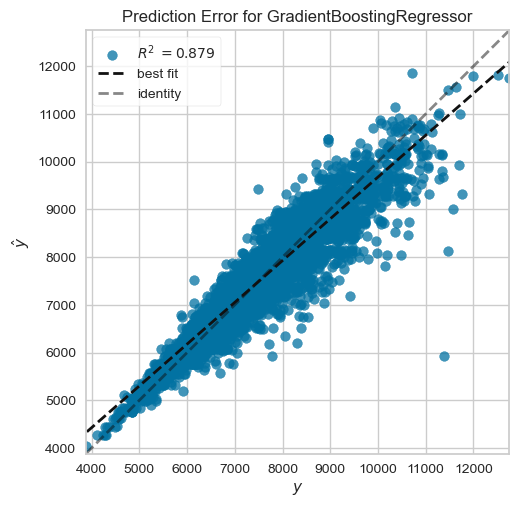

In [48]:
plot_model(best_model, plot='error')

In [49]:
best_final_model = exp.finalize_model(best_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Gender', '5 km Time'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=['Age Category'],
                                    transfor...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           random_state=123, subsample=1.0,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

In [50]:
exp.save_model(best_final_model, "best_time_model");

Transformation Pipeline and Model Successfully Saved


In [70]:
s3.upload_file("best_time_model.pkl", BUCKET_NAME, "best_time_model.pkl")

# Załadowanie i test modelu na podanych danych

In [55]:
# 1. Załaduj zapisany model
model = load_model('best_time_model')  # Podaj nazwę pliku modelu bez rozszerzenia '.pkl'

# 2. Przygotuj nowe dane do predykcji (musi mieć takie same cechy jak dane treningowe)
new_data = pd.DataFrame({
    'Gender': [1],  # Przykładowe dane
    'Age Category': [20],
    '5 km Time': [1560],
    # Dodaj więcej cech zgodnie z danymi treningowymi
})

# 3. Wykonaj predykcje
predictions = predict_model(model, data=new_data)

predictions = predictions.rename(columns={'prediction_label': 'Predicted_time_of_halfmarathon'})
# Wyświetl wynik predykcji
print(predictions)




Transformation Pipeline and Model Successfully Loaded


   Gender  Age Category  5 km Time  Predicted_time_of_halfmarathon
0       1            20       1560                     6825.258512
